# Text classification for topic-specific newspaper collections

Text classification is the process of categorizing text into pre-defined groups. By using Natural Language Processing (NLP), text classifiers can automatically analyze text and then assign a set of given categories based on the research question. This automated classification of text into predefined categories is an important method for managing and processing a large number of newspaper clippings. This also applies to subcorpora for a specific research topic (e.g. migration). The aim of this notebook is to train a model using your previously manually created training/test corpus and to use this model to get an overview of the category distribution throughout your collection (see figure below). Another goal is to export your categorized data for further analysis. This makes it possible to examine, for example, the advertisement about a specific topic.

This notebook was used with a collection for the case study on emigration (1850-1950) and shows how a model can be trained to classify topic-specific collections. For the training/testing corpus, a collection with the keywords "Auswander*", "Ausgewanderte", "Emigrant*", "Emigrierte", "Emigration", "Kolonist*", and "Ansiedler*" (all different German words for emigrants or emigration) have been created. In addition, information on the pre-defined gropus (news, ads, culture...) were added using numbers between one and ten. 

For classification, topic modelling (LDA) was chosen because it showed the best performance in classification (after experiments with word embeddings or LDA and word embeddings combined). LDA provides a way to group documents by topic and perform similarity searches and improve precision. Thanks to sklearn, it is relatively easy to test different classifiers for a given topic classification task. Logistic regression was chosen as binary classifier. 

*Following graph demonstrates the distribution of the pre-defined categories in newspaper clippings of seleceted Austrian Newspapers (sample of 1631 newspaper clippings) on the topic of emigration.* 

![Collection on the topic of Emigration](images/cat.PNG)


Read more about <a href="https://monkeylearn.com/blog/introduction-to-topic-modeling/" target="_blank">Topic Modeling</a> and <a href="https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5" target="_blank">Logistic Regression Model Tuning</a>.

Acknowledgments:

This work has been inspired by a notebook on <a href="https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec" target="_blank">LDA and word embeddings</a> and several other soursces that provided help on how to buid models. This work was supported by the European Union's Horizon 2020 research and innovation programme under grant 770299 (NewsEye).

## Step by step...
* [Prepare a small manually annotated collection](#1-bullet)
* [Install packages in command line](#2-bullet)
* [Import packages](#3-bullet)
* [Import your manually annotated newspaper collection](#4-bullet)
* [Clean and tokenize the text (pre-processing)](#5-bullet)
* [Have a look at your data](#6-bullet)
* [Use your dataset to create a training corpus and test corpus](#7-bullet)
* [Create topic models using your training corpus](#8-bullet)
* [Have a look at your topics](#9-bullet)
* [Create the feature vector ](#10-bullet)
* [Have a look at the top words for each category](#11-bullet)
* [Classification and hyperparameter tuning](#12-bullet)
* [Using the test corpus](#13-bullet)
* [Logistic Regression](#14-bullet)
* [Now it is time to make the classifications](#15-bullet)
* [Calculate the score for each category as well as the overall score](#16-bullet)
* [If your overall score is higher than 80 percent, you can start to use your whole collection](#17-bullet)
* [Clean (pre-process) your whole collection](#18-bullet)
* [Now it is time to make the classifications for the whole collection](#19-bullet)
* [Create a dataframe with the results](#20-bullet)
* [If you are satisfied with the results, you can save them in the form of your original file](#21-bullet)
* [Visualize your results](#22-bullet)


## Prepare a small manually annotated collection <a class="anchor" id="1-bullet"></a>

This program uses annotations for evaluation and classification. Therefore, a manually annotated collection of  80 to 100 articles per category is needed to work with this program. To create this collection, the numbers 0 to 7 have been assignet to the articles, each number representing one newspaper category (ads, news, culture_literature_stories_letters, appeals_donations_information, crime, finance, statistic). When you create your own collection, make sure you create a representative collection of the whole search result. If you use a long time period, make sure all timer periods are represented in your small collection. 
The newspaper articles with the annotations should be saved as CSV.

## Install packages in command line <a class="anchor" id="2-bullet"></a>
 
If you need help on how to pip install, have a look at this tutorial: https://packaging.python.org/tutorials/installing-packages/

pip install gensim

pip install PyLDAvis

pip install spacy

python -m spacy download de_core_web_sm

pip install pandas

pip install regex

pip install nltk

pip install matplotlib

pip install numpy

pip install seaborn

pip install sklearn

## Import packages <a class="anchor" id="3-bullet"></a>

Before you can get started, you have to install and import some packages.

#### Make sure you use the version 1.9.0 with smart_open: python -m pip install --upgrade smart_open==1.9.0


In [1]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re
import sys
import time

# preprocessing imports
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.utils import lemmatize, simple_preprocess
import spacy

# model imports
from gensim.models.ldamulticore import LdaMulticore
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# LDA
import nltk
import gensim
from gensim.corpora import Dictionary
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from gensim.models import LdaModel
from gensim import models, corpora, similarities

# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline


# Frequency
from nltk import FreqDist


In [2]:
pd.set_option('mode.chained_assignment', None)

## Import your manually annotated newspaper collection <a class="anchor" id="4-bullet"></a>
And have a look at your data

In [3]:
df = pd.read_csv('export_classification_emigration_new_06_07_2020_23_15.csv')

print(df.shape)
df.head(3)

(673, 7)


,id,language,date,newspaper_id,iiif_url,relevancy,text
0,arbeiter_zeitung_aze19131209_article_127,de,1913-12-09T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,4,* Betrug an Auswanderern. Am 5. d. abends wurd...
1,illustrierte_kronen_zeitung_krz19390921_articl...,de,1939-09-21T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,4,"Donnerstag, 21. September 1939\n Das Ergebnis ..."
2,arbeiter_zeitung_aze19121018_article_191,de,1912-10-18T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,4,Die maßlosen Schurkereien der Grenzpolizeibehö...


### Check the distribution of your annotated categories. 
Each category is assignet to a number: 

0 = Advertisements
 
1 = News

2 = Culture, Literature, Stories, and Letters

3 = Appeals, Donations, and (help) informations

4 = Crime

6 = Finance

7 = Statistic

These categories where specifically chosen for a collection on emigration between 1850 and 1950. For this corpus, about 80 articles for each categorie were sufficient to train a model that delivers good results. However, it is important that the corpus is representative for this specific topic. 

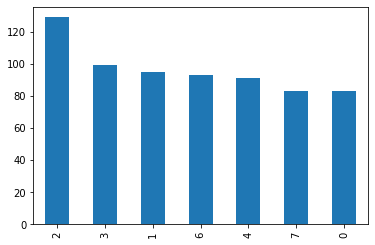

In [4]:
df.relevancy.value_counts().plot(kind='bar')

## Clean and tokenize the text (pre-processing) <a class="anchor" id="5-bullet"></a>

Before you can start with the training fo the topic models, you have to clean the text of your newspaper articles. The follwing functions remove punctuations, lower case the text, remove stop words and lemmatize the text. 

#### Stop words: 
You can change the language used for the stop words. You can also add your own stop words or other words you would like to ignore. It helps to ignore your search keywords. 

In [5]:
# Functions to clean, tokenize, and lemmatize the data
def initial_clean(text):
    text = re.sub(r'[^\w\s]','',text)
    text = text.lower() 
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('german')#change the language here
# add your onw stop words
stop_words.extend(['auswanderer', 'auswanderung', 'auswanderern'])
def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError: 
        pass
    return text

def apply_all(text):
    return stem_words(remove_stop_words(initial_clean(text)))

In [6]:
df['tokenized'] = df['text'].apply(apply_all) 

## Have a look at your data <a class="anchor" id="6-bullet"></a>

Check out, if everything went alright so far. Have a look at the number of words and their frequency distribution.

In [7]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
f"The number of unique words is {len(fdist)}"

'The number of unique words is 17324'

In [8]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print(f"length of list: {len(doc_lengths)}")
print(f"average document length: {np.average(doc_lengths)}")
print(f"minimum document length: {min(doc_lengths)}")
print(f"maximum document length: {max(doc_lengths)}")

length of list: 673
average document length: 73.64041604754829
minimum document length: 4
maximum document length: 602



## Use your dataset to create a training corpus and test corpus <a class="anchor" id="7-bullet"></a>

Before we use our model on a bigger, unseen collection, we use our manual annotated dataset to train the models and classify the newspaper clippings. This helps to control the output (the annotations show if the automated classification has worked corretly) and to adapt the code in order to get the best results for your own collection. 

You can change the size of training and testing corpus by changing the number in following line: msk = np.random.rand(len(df)) < 0.899


In [9]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.899

In [10]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [11]:
print(len(df),len(train_df),len(test_df))

673 595 78


### Make sure, all categories have the same size
Therefore we shorten the training corpus to the number of the smallest category in the corpus. This is important so that the results are not distorted by over- or under-representation of a category. 

In [12]:
val = train_df.relevancy.value_counts().min()
train_df = train_df.groupby('relevancy').head(val)

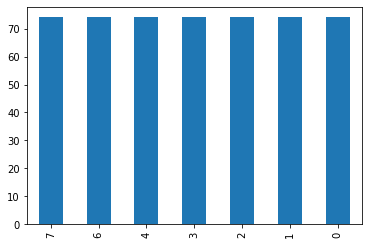

In [13]:
train_df.relevancy.value_counts().plot(kind='bar')

### Have a look at the training corpus
Make sure there are enough articles of each category represented in the training corpus. The training corpus will be used to mesure the score of the classfication results by using the manual assigned information. 

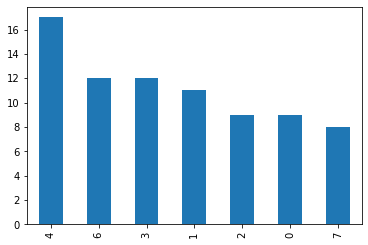

In [14]:
test_df.relevancy.value_counts().plot(kind='bar')

## Create topic models using your training corpus <a class="anchor" id="8-bullet"></a>

The function "train_lda" trains the lda model. You can change the parameters like number of topics or chunksize, but also the change of the alpha and eta parameters can change the results a lot. For the text classification, a high number of topics is best suited. Of course, this can change from research question to research question, and it makes sense to train your models with a changing number of topics to find out which amount works best for your collection.

The program is doing also several passes of the data since this is a small dataset, so we want the distributions to stabilize. 

It is also important to note that changing the parameters may lead to better results for some categories but worse results for others. If an overall good result is important, the parameters should be adjusted accordingly. On the other hand, if a good result is important for certain categories, you can simply ignore the result of those you do not need. The score is calculated after the model has been trained and the collection classified. To find out, which parameters work the best for your corpus, you simply have to try out a view times and see what happens when you change the parameters. Every collection is different.   


In [15]:
dictionary = corpora.Dictionary(train_df['tokenized'])

In [16]:
#Make a BOW for every document (Bag of words)
def document_to_bow(df):
    train_df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), train_df['tokenized']))
    
document_to_bow(train_df)

In [17]:
corpus = train_df.bow

In [18]:
def train_lda(data):
    num_topics = 500
    chunksize = 8000
    t1 = time.time()
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                    chunksize=chunksize, minimum_probability=0.0, passes=50, iterations=500, per_word_topics=True)
    return dictionary,corpus,lda

#### The training of the topic models takes a few minutes. But it is worh the waiting time

In [19]:
%%time
dictionary,corpus,lda = train_lda(train_df)

Wall time: 4min 28s


## Have a look at your topics <a class="anchor" id="9-bullet"></a>
Inspect the outcome of your topics. You can see all your topics in changing the topicid to the number of topic you want to see. You can also adapt the number of tokens (topn) by changing the number. 

In [20]:
lda.show_topic(topicid=0, topn=20)

[('deutschösterreich', 7.2748444e-05),
 ('erschöpft', 7.2748444e-05),
 ('fensterscheiben', 7.2748444e-05),
 ('figaro', 7.2748444e-05),
 ('endlo', 7.2748444e-05),
 ('ergiebig', 7.2748444e-05),
 ('bahnhofsinspektor', 7.2748444e-05),
 ('denk', 7.2748444e-05),
 ('centim', 7.2748444e-05),
 ('bücken', 7.2748444e-05),
 ('börsenkur', 7.2748444e-05),
 ('butterschiebungen', 7.2748444e-05),
 ('butter', 7.2748444e-05),
 ('brote', 7.2748444e-05),
 ('bourdoi', 7.2748444e-05),
 ('bossischen', 7.2748444e-05),
 ('beliebt', 7.2748444e-05),
 ('dito', 7.2748444e-05),
 ('ausplünderung', 7.2748444e-05),
 ('endlos', 7.2748444e-05)]

## Now it is time to create the feature vector <a class="anchor" id="10-bullet"></a>
Freature vectore is an n-dimensional vector of numerical features that represent some object. Many algorithms in machine learning require a numerical representation of objects, since such representations facilitate processing and statistical analysis.

In [21]:
def document_to_lda_features(lda, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = lda.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

train_df['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(lda, doc),
                                      train_df.bow))

In [22]:
ads_topic_distribution = train_df.loc[train_df.relevancy == 0, 'lda_features'].mean()
news_topic_distribution = train_df.loc[train_df.relevancy == 1, 'lda_features'].mean()
culture_topic_distribution = train_df.loc[train_df.relevancy == 2, 'lda_features'].mean()
appeals_topic_distribution = train_df.loc[train_df.relevancy == 3, 'lda_features'].mean()
crime_topic_distribution = train_df.loc[train_df.relevancy == 4, 'lda_features'].mean()
finances_topic_distribution = train_df.loc[train_df.relevancy == 6, 'lda_features'].mean()
statistic_topic_distribution = train_df.loc[train_df.relevancy == 7, 'lda_features'].mean()

## Have a look at the top words for each category <a class="anchor" id="11-bullet"></a>

In [23]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [24]:
for relevancy, distribution in zip(['ads', 'news', 'culture', 'appeals', 'crime', 'finances', 'statistic'], [ads_topic_distribution, news_topic_distribution, culture_topic_distribution, appeals_topic_distribution, crime_topic_distribution, finances_topic_distribution, statistic_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(relevancy))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(lda, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from ads.
For topic 47, the top words are: wegen, verkaufen, bez, billig, 17.
For topic 91, the top words are: wien, bezirk, auskunft, auskunftsstel, 16.
For topic 244, the top words are: jahr, englisch, spanisch, verlust, mann.
For topic 412, the top words are: sucht, konstantinopel, de, nachdem, stell.
For topic 460, the top words are: uhr, rumänischen, freien, neuen, press.

Looking up top words from top topics from news.
For topic 87, the top words are: gesellschaft, venezuela, errichtet, fl, anfragen.
For topic 266, the top words are: wien, jahr, ottendorf, jedoch, oswald.
For topic 454, the top words are: liverpool, folg, cholera, queenstown, hafen.
For topic 473, the top words are: fahrt, gesuch, ueberfahrt, dampfer, versenkt.
For topic 487, the top words are: eriwan, armenisch, abgeschoben, berichtet, grenz.

Looking up top words from top topics from culture.
For topic 120, the top words are: tirol, heimat, zillertal, brieftasch, papier.
For

## Classification and hyperparameter tuning <a class="anchor" id="12-bullet"></a>
After transforming the documents into features, it is important to apply a few supervised classifiers to be able to predict what text belongs to which category.

In [25]:
def get_cross_validated_model(model, param_grid, X, y, nr_folds=6):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=nr_folds, n_jobs=-1, verbose=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'rank_test_score']
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [26]:
# we first have to transform every entry
X_train_lda = np.array(list(map(np.array, train_df.lda_features)))



## Using the test corpus  <a class="anchor" id="13-bullet"></a>
First, have a look at your test corpus

In [27]:
test_df.head()

,id,language,date,newspaper_id,iiif_url,relevancy,text,tokenized
0,illustrierte_kronen_zeitung_krz19390921_articl...,de,1939-09-21T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,4,"Donnerstag, 21. September 1939\n Das Ergebnis ...","[donnerstag, 21, septemb, 1939, ergebni, verei..."
1,illustrierte_kronen_zeitung_krz19391010_articl...,de,1939-10-10T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,4,Auf Grund der Ergebnisse des Beweisverfahrens ...,"[grund, ergebniss, beweisverfahren, wurd, bezü..."
2,arbeiter_zeitung_aze19140403_article_97,de,1914-04-03T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,4,Bestochene Gendarmen im Dienste der Auswanderu...,"[bestochen, gendarmen, dienst, auswanderungsag..."
3,arbeiter_zeitung_aze19130608_article_298,de,1913-06-08T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,4,(Auswanderer bestohlen.) Am 30. Jänner erschie...,"[bestohlen, 30, jänner, erschien, hiesigen, ze..."
4,arbeiter_zeitung_aze19131121_article_63,de,1913-11-21T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,7,Danach wurde die Verhandlung wieder sachlich. ...,"[danach, wurd, verhandlung, sachlich, zuerst, ..."


#### Pre-process your test corpus using the same function than for the train corpus

In [28]:
test_df['tokenized'] = test_df['text'].apply(apply_all) 

#### Make a bag of words for every document

In [29]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), test_df['tokenized']))
    
document_to_bow(test_df)

#### Get feature vectores for your test corpus

In [30]:
test_df['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(lda, doc),
                                     test_df.bow))

In [31]:
X_test_lda = np.array(list(map(np.array, test_df.lda_features)))

In [32]:
# store all models in a dictionary
models = dict()

## Logistic Regression <a class="anchor" id="14-bullet"></a>
Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [33]:

lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_lda = get_cross_validated_model(lr, param_grid, X_train_lda, train_df.relevancy)

models['best_lr_lda'] = best_lr_lda

Fitting 6 folds for each of 2 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    3.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.9s finished


,mean_test_score,rank_test_score,param_penalty
1,-1.739082,1,l2
0,NaN,2,l1


## Now it is time to make the classifications  <a class="anchor" id="15-bullet"></a>
First we get a data frame with the result for each category. The category with the highest number is the category to which the article is assigned. 


In [34]:
submission_predictions = best_lr_lda.predict_proba(X_test_lda)

In [35]:
result= np.append(test_df.relevancy.values.reshape(-1,1), submission_predictions, axis=1)

In [36]:
submission_df = pd.DataFrame(data=result, columns=['relevancy', 'ads', 'news', 'culture', 'appeals', 'crime', 'finance', 'statistic'])

#### Have a look if everything worked correctly
The first article contains the manual annotation (4.0), which means this article belongs to the category of crime. As you can see, the highest number for this row is in the column of crime. So this article has been classified correctly. 

In [37]:
submission_df.head(5)

,relevancy,ads,news,culture,appeals,crime,finance,statistic
0,4.0,0.128170,0.151379,0.141994,0.123772,0.163076,0.145021,0.146587
1,4.0,0.135305,0.136371,0.133846,0.106168,0.210156,0.134451,0.143702
2,4.0,0.109508,0.118256,0.121030,0.090535,0.337691,0.112739,0.110241
3,4.0,0.137094,0.140410,0.139888,0.108211,0.218468,0.132532,0.123397
4,7.0,0.127070,0.143800,0.155163,0.103319,0.127259,0.151929,0.191461


## Calculate the score for each category as well as the overall score  <a class="anchor" id="16-bullet"></a>
Repeat the calculation (topic models need sometimes several rounds) or adapt the code until you get a higher score than 80 percent. If you get a higher score than 80 percent, you can continue with your whole dataset.

In [38]:
max_num = submission_df.loc[:, submission_df.columns != 'relevancy'].max(axis=1)

In [39]:

df_ads = submission_df[['ads', 'relevancy']][submission_df['ads'].isin(max_num)]

ads_list = []
for key, value in df_ads.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            ads_list.append(rel)

ads_right = []
ads_wrong =[]
for num in ads_list: 
    if num == 0.0: 
        ads_right.append(num)
    else: 
        ads_wrong.append(num)
all_ = len(ads_right) + len(ads_wrong)
ads_score = len(ads_right) / all_
print(f"Your score for ads is: {ads_score}")

df_news = submission_df[['news', 'relevancy']][submission_df['news'].isin(max_num)]


news_list = []
for key, value in df_news.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            news_list.append(rel)

news_right = []
news_wrong =[]
for num in news_list: 
    if num == 1.0: 
        news_right.append(num)
    else: 
        news_wrong.append(num)
all_ = len(news_right) + len(news_wrong)
news_score = len(news_right) / all_
print(f"Your score for news is: {news_score}")

    
df_culture = submission_df[['culture', 'relevancy']][submission_df['culture'].isin(max_num)]

culture_list = []
for key, value in df_culture.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            culture_list.append(rel)

culture_right = []
culture_wrong =[]
for num in culture_list: 
    if num == 2.0: 
        culture_right.append(num)
    else: 
        culture_wrong.append(num)
all_ = len(culture_right) + len(culture_wrong)
culture_score = len(culture_right) / all_
print(f"Your score for culture is: {culture_score}")

df_appeals = submission_df[['appeals', 'relevancy']][submission_df['appeals'].isin(max_num)]

appeals_list = []
for key, value in df_appeals.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            appeals_list.append(rel)

appeals_right = []
appeals_wrong =[]
for num in appeals_list: 
    if num == 3.0: 
        appeals_right.append(num)
    else: 
        appeals_wrong.append(num)
all_ = len(appeals_right) + len(appeals_wrong)
appeals_score = len(appeals_right) / all_
print(f"Your score for appeals is: {appeals_score}")

df_crime = submission_df[['crime', 'relevancy']][submission_df['crime'].isin(max_num)]

crime_list = []
for key, value in df_crime.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            crime_list.append(rel)

crime_right = []
crime_wrong =[]
for num in crime_list: 
    if num == 4.0: 
        crime_right.append(num)
    else: 
        crime_wrong.append(num)
all_ = len(crime_right) + len(crime_wrong)
crime_score = len(crime_right) / all_
print(f"Your score for crime is: {crime_score}")


df_finances = submission_df[['finance', 'relevancy']][submission_df['finance'].isin(max_num)]

finances_list = []
for key, value in df_finances.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            finances_list.append(rel)

finances_right = []
finances_wrong =[]
for num in finances_list: 
    if num == 6.0: 
        finances_right.append(num)
    else: 
        finances_wrong.append(num)
all_ = len(finances_right) + len(finances_wrong)
finance_score = len(finances_right) / all_
print(f"Your score for finances is: {finance_score}")
   
df_statistic = submission_df[['statistic', 'relevancy']][submission_df['statistic'].isin(max_num)]

statistic_list = []
for key, value in df_statistic.items(): 
    for rel in value: 
        if len(str(rel)) < 4:
            statistic_list.append(rel)

statistic_right = []
statistic_wrong =[]
for num in statistic_list: 
    if num == 7.0: 
        statistic_right.append(num)
    else: 
        statistic_wrong.append(num)
all_ = len(statistic_right) + len(statistic_wrong)
statistic_score = len(statistic_right) / all_
print(f"Your score for statistic is: {statistic_score}")
overall_score = (ads_score + news_score + culture_score + appeals_score + crime_score + finance_score + statistic_score) / 7

print(f"Your overall score is {overall_score}")

Your score for ads is: 1.0
Your score for news is: 0.6
Your score for culture is: 0.7777777777777778
Your score for appeals is: 0.9230769230769231
Your score for crime is: 0.8125
Your score for finances is: 0.8181818181818182
Your score for statistic is: 0.8571428571428571
Your overall score is 0.8269541965970537


# If your overall score is higher than 80 percent, you can start to use your whole collection  <a class="anchor" id="17-bullet"></a>

Start with importing your whole collection. Import the same collection twice for the futher processing. 

Note: If you are mainly interested in one of the catecories, it makes sense to choose a model with a high score for that category. If you want a good overview of the distribution of the categories, a overall good score is more important. 

In [40]:
df_all = pd.read_csv('export_auswanderer_06_07_2020_22_38.csv', usecols = ['id','language','date','newspaper_id','iiif_url','text'])
df_all_2 = pd.read_csv('export_auswanderer_06_07_2020_22_38.csv', usecols = ['id','language','date','newspaper_id','iiif_url','text'])


### Have a look at your data

In [41]:
df_all.head()

,id,language,date,newspaper_id,iiif_url,text
0,illustrierte_kronen_zeitung_krz19390708_articl...,de,1939-07-08T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,schafft.\nIn dieser Vereinigung werden die Ju...
1,illustrierte_kronen_zeitung_krz19390708_articl...,de,1939-07-08T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,"Die Reichsvereinigung ist verpflichtet, für di..."
2,illustrierte_kronen_zeitung_krz19131101_articl...,de,1913-11-01T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,(Angehaltene Auswanderer.) In Prag wurden\nges...
3,illustrierte_kronen_zeitung_krz19331108_articl...,de,1933-11-08T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,gestern eine Festsitzung statt. Direktor\nSchw...
4,arbeiter_zeitung_aze19131231_article_196,de,1913-12-31T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,Der Portier eines Leopoldstädter Hotels gab al...


## Clean (pre-process) your whole collection <a class="anchor" id="18-bullet"></a>

You repeat the same steps you did with your training and test corpus

In [42]:
df_all['tokenized'] = df_all['text'].apply(apply_all) 

#### Again, have a look at your data

In [43]:
# first get a list of all words
all_words = [word for item in list(df_all['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
f"The number of unique words is {len(fdist)}"

'The number of unique words is 22702'

In [44]:
#document length
df_all['doc_len'] = df_all['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df_all['doc_len'])
df_all.drop(labels='doc_len', axis=1, inplace=True)


print(f"length of list: {len(doc_lengths)}")
print(f"average document length: {np.average(doc_lengths)}")
print(f"minimum document length: {min(doc_lengths)}")
print(f"maximum document length: {max(doc_lengths)}")

length of list: 1894
average document length: 41.554382259767685
minimum document length: 0
maximum document length: 430


#### Remove articles that are smaller than 5 tokens

In [45]:
df_all = df_all[df_all['tokenized'].map(len) >= 5]
df_all = df_all[df_all['tokenized'].map(type) == list]
df_all.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df_all), "articles")

df_all_2 = df_all[df_all['tokenized'].map(len) >= 5]
df_all_2 = df_all[df_all['tokenized'].map(type) == list]
df_all_2.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df_all), "articles")

After cleaning and excluding short aticles, the dataframe now has: 1631 articles
After cleaning and excluding short aticles, the dataframe now has: 1631 articles


#### Make a BOW (bag of words) for every document and get feature vectores for your whole collection

In [46]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df_all['tokenized']))
    
document_to_bow(df_all)

In [47]:
df_all['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(lda, doc),
                                     df_all.bow))

In [48]:
X_all_lda = np.array(list(map(np.array, df_all.lda_features)))

## Now it is time to make the classifications for the whole collection <a class="anchor" id="19-bullet"></a>

In [49]:
submission_predictions = best_lr_lda.predict_proba(X_all_lda)

To be able to create two different outputs, one with the results per category to check the result [57] and one with the results in the form of your original file [61], two different types of results are created. 

In [50]:
result= np.append(df_all.text.values.reshape(-1,1), submission_predictions, axis=1)


In [51]:
result_2= np.append(df_all_2, submission_predictions, axis=1)

In [52]:
submission_df_all = pd.DataFrame(data=result, columns=['text', 'ads', 'news', 'culture', 'appeals', 'crime', 'finance', 'statistic'])
submission_df_all_2 = pd.DataFrame(data=result_2, columns=['id','language','date','newspaper_id','iiif_url','text', 'token', 'ads', 'news', 'culture', 'appeals', 'crime', 'finance', 'statistic'])

In [53]:
submission_df_all.head(5)

,text,ads,news,culture,appeals,crime,finance,statistic
0,schafft.\nIn dieser Vereinigung werden die Ju...,0.127635,0.195056,0.133611,0.0988736,0.12577,0.182054,0.137
1,"Die Reichsvereinigung ist verpflichtet, für di...",0.12317,0.206848,0.132327,0.115848,0.127157,0.170397,0.124253
2,(Angehaltene Auswanderer.) In Prag wurden\nges...,0.128026,0.127883,0.110097,0.102477,0.289,0.11354,0.128977
3,gestern eine Festsitzung statt. Direktor\nSchw...,0.133976,0.163399,0.131451,0.117312,0.188189,0.140498,0.125174
4,Der Portier eines Leopoldstädter Hotels gab al...,0.144175,0.136877,0.122825,0.107205,0.155244,0.204618,0.129055


## Create a dataframe with the results <a class="anchor" id="20-bullet"></a>

In [58]:
max_num = submission_df_all.loc[:, submission_df_all.columns != 'text'].max(axis=1)

In [59]:
ads = submission_df_all[['text']][submission_df_all['ads'].isin(max_num)]
news = submission_df_all[['text']][submission_df_all['news'].isin(max_num)]
culture = submission_df_all[['text']][submission_df_all['culture'].isin(max_num)]
appeals = submission_df_all[['text']][submission_df_all['appeals'].isin(max_num)]
crime = submission_df_all[['text']][submission_df_all['crime'].isin(max_num)]
finance = submission_df_all[['text']][submission_df_all['finance'].isin(max_num)]
statistic = submission_df_all[['text']][submission_df_all['statistic'].isin(max_num)]

In [60]:
#transform your lists into a dataframe

df_ads = pd.DataFrame(np.column_stack([ads]), 
                               columns=['Ads'])


df_news = pd.DataFrame(np.column_stack([news]), 
                               columns=['News'])

df_culture = pd.DataFrame(np.column_stack([culture]), 
                               columns=['Culture_Literature'])

df_appeals = pd.DataFrame(np.column_stack([appeals]), 
                               columns=['Appeals_Donations'])

df_crime = pd.DataFrame(np.column_stack([crime]), 
                               columns=['Crime'])



df_finance = pd.DataFrame(np.column_stack([finance]), 
                               columns=['Finance'])

df_statistic = pd.DataFrame(np.column_stack([statistic]), 
                               columns=['Statistic'])

df_results = pd.concat([df_ads, df_news, df_culture, df_appeals, df_crime, df_finance, df_statistic], ignore_index=True, axis=1)
df_results.columns=['Ads','News', 'Culture_Literatur', 'Appeals_Donations', 'Crime', 'Finance', 'Statistic']
df_results[15:20]

,Ads,News,Culture_Literatur,Appeals_Donations,Crime,Finance,Statistic
15,"furse für Französisch,\nItalienisch, Ungarisch...",Imperialisten nicht. Die meisten industriellen...,"Wir waren wieder die letzten, die den Zug\nver...","I, Neuet indent% stration des Blattes „Der Aus...",* Kleine Nachrichten. Der 31jährige Comptoiris...,"Die beiden Schiffe, die die Auswanderer\nnach ...",Es wandern mehr Frauen aus.\n Gegenüber den Vo...
16,"Auswanderer einer raschen, exergischen Regelun...",Tripolitanien als Auswanderungsland ist Humbug...,Dem Auswanderungsamt muß auch eine staatliche ...,Saal: 4 Uhr: „Im Firnenglanz des Ober=Engadin“...,(Der Raubmordversuch an einem Auswanderer.) Un...,scheinsalscher\nDer jüdische Kaufmann Karl Fah...,Danach wurde die Verhandlung wieder sachlich. ...
17,& Auswanderer 9\nWege aller Art\nTaramt schan ...,Der erste Redner ist Delegirter Graf Dzieduszy...,(Für Auswanderer.) Heute 7 Uhr abends\nspricht...,Die Alhambra in Granada.\nAbends ½8 Uhr:\nAusw...,Auf Grund der Ergebnisse des Beweisverfahrens ...,Arbeiter dieses kapitalistische Denkmal errich...,Während im ganzen Jahre 1912 über Triest nur 1...
18,Für Auswanderer\nprima Existenz. Verkaufe\nlei...,Die jüdische Politik kenne keine Grenzen\nfür ...,In Ecuador ist für Auswanderer nichts\nzu hole...,"Urania.\nSonntag, 26., 3 Uhr: Großer\nVortrags...",schwiegen\nWie eine Auswanderung finanziert we...,"sch, Ungarisch, Tschechif\npanischer und portu...",Die Mitteilungen des Handelsministers wurden d...
19,"umarbeiten, mode\nnisieren, auch für\nAuswande...",d) für Reichsangehörige und Angehörige\ndes Pr...,Der Jakob schüttelte den Kopf.\n„Besuch' mich ...,Achtung Auswanderer!\nKostenlose Ueberfahrt un...,Die Angeklagte reiste nach der Auswanderung ih...,Die „Abtreibungsklinik“ des Artisten\nSchädlin...,"monen zur Auswanderung veranlaßten, aber die U..."


### Now export your dataframe in order to check the results

In [61]:
df_results.to_excel("results_emigration.xlsx") 

### Get the dates for your classified articles
You will need them later for the visualization

In [62]:
# Extract the dates for the visualization for every category
date_ads = []
ads = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['ads'].isin(max_num)]
date = submission_df_all_2['date'][submission_df_all['ads'].isin(max_num)]
for key in date: 
    date_ads.append(key[:4])
# Transform the dates from strings to integers
for i in range(0, len(date_ads)): 
    date_ads[i] = int(date_ads[i]) 
news = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['news'].isin(max_num)]
date_news = []
date = submission_df_all_2['date'][submission_df_all['news'].isin(max_num)]
for key in date: 
    date_news.append(key[:4])
for i in range(0, len(date_news)): 
    date_news[i] = int(date_news[i])
culture = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['culture'].isin(max_num)]
date_culture = []
date = submission_df_all_2['date'][submission_df_all['culture'].isin(max_num)]
for key in date: 
    date_culture.append(key[:4])
for i in range(0, len(date_culture)): 
    date_culture[i] = int(date_culture[i])
appeals = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['appeals'].isin(max_num)]
date_appeals = []
date = submission_df_all_2['date'][submission_df_all['appeals'].isin(max_num)]
for key in date: 
    date_appeals.append(key[:4])
for i in range(0, len(date_appeals)): 
    date_appeals[i] = int(date_appeals[i])
crime = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['crime'].isin(max_num)]
date_crime = []
date = submission_df_all_2['date'][submission_df_all['crime'].isin(max_num)]
for key in date: 
    date_crime.append(key[:4])
for i in range(0, len(date_crime)): 
    date_crime[i] = int(date_crime[i])
finance = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['finance'].isin(max_num)]
date_finance = []
date = submission_df_all_2['date'][submission_df_all['finance'].isin(max_num)]
for key in date: 
    date_finance.append(key[:4])
for i in range(0, len(date_finance)): 
    date_finance[i] = int(date_finance[i])
statistic = submission_df_all_2[['id','language','date','newspaper_id','iiif_url','text']][submission_df_all['statistic'].isin(max_num)]
date_statistic = []
date = submission_df_all_2['date'][submission_df_all['statistic'].isin(max_num)]
for key in date: 
    date_statistic.append(key[:4])
for i in range(0, len(date_statistic)): 
    date_statistic[i] = int(date_statistic[i])

## If you are satisfied with the results, you can save them in the form of your original file <a class="anchor" id="21-bullet"></a>

Otherwise, try to repeat the process

In [63]:
#transform your lists into a dataframe

df_ads = pd.DataFrame(np.column_stack([ads]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])


df_news = pd.DataFrame(np.column_stack([news]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])

df_culture = pd.DataFrame(np.column_stack([culture]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])

df_appeals = pd.DataFrame(np.column_stack([appeals]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])

df_crime = pd.DataFrame(np.column_stack([crime]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])

df_finance = pd.DataFrame(np.column_stack([finance]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])

df_statistic = pd.DataFrame(np.column_stack([statistic]), 
                               columns=['id','language','date','newspaper_id','iiif_url','text'])


### Have a look at your data
you can create this for every category

In [64]:
df_news

,id,language,date,newspaper_id,iiif_url,text
0,illustrierte_kronen_zeitung_krz19390708_articl...,de,1939-07-08T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,schafft.\nIn dieser Vereinigung werden die Ju...
1,illustrierte_kronen_zeitung_krz19390708_articl...,de,1939-07-08T00:00:00Z,illustrierte_kronen_zeitung,https://platform.newseye.eu/iiif/illustrierte_...,"Die Reichsvereinigung ist verpflichtet, für di..."
2,arbeiter_zeitung_aze19140628_article_125,de,1914-06-28T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,Der griechisch=türkische Konflikt.\nDie Antwor...
3,arbeiter_zeitung_aze19140628_article_126,de,1914-06-28T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,In hiesigen diplomatischen Kreisen glaubt man ...
4,arbeiter_zeitung_aze19140626_article_138,de,1914-06-26T00:00:00Z,arbeiter_zeitung,https://platform.newseye.eu/iiif/arbeiter_zeit...,Dieser Aufruf ist ja sehr heiter. Er gibt aber...
...,...,...,...,...,...,...
422,neue_freie_presse_nfp18650524_article_558,de,1865-05-24T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Wegen Mexicos, welches übrigens alles Andere i..."
423,neue_freie_presse_nfp18650924_article_114,de,1865-09-24T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,Der Hunger und die Auswanderung haben das Ihri...
424,neue_freie_presse_nfp18651007_article_105,de,1865-10-07T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,"Fiume, 4. October. [Orig.=Corr.] (Zichy's Bros..."
425,neue_freie_presse_nfp19111221_article_5882,de,1911-12-21T00:00:00Z,neue_freie_presse,https://platform.newseye.eu/iiif/neue_freie_pr...,Dr. Ktein nder das Baupfgndracht. Interpenlatl...


### Export your categorised collections

In [65]:
df_news.to_csv('collection_news.csv')

## Visualize your results <a class="anchor" id="21-bullet"></a>
First, we are going to create a pie chart showing the distribution of every category

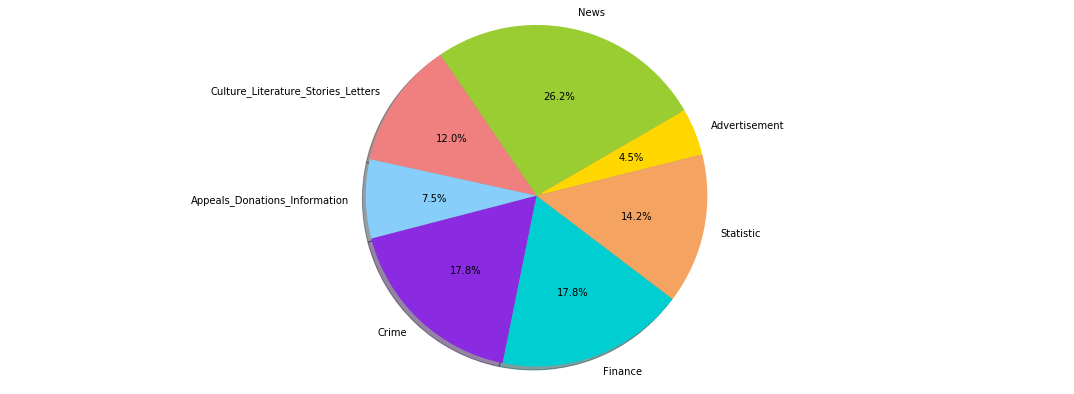

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(19, 7))
# Data to plot
labels = 'Advertisement', 'News', 'Culture_Literature_Stories_Letters', 'Appeals_Donations_Information', 'Crime', 'Finance', 'Statistic'
sizes = [len(ads), len(news), len(culture), len(appeals), len(crime), len(finance), len(statistic)]
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'blueviolet', 'darkturquoise', 'sandybrown', 'pink']
explode = (0, 0, 0, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=14)

plt.axis('equal')
plt.show()

Finally, we are creating histograms to find out which category was very popular at what time

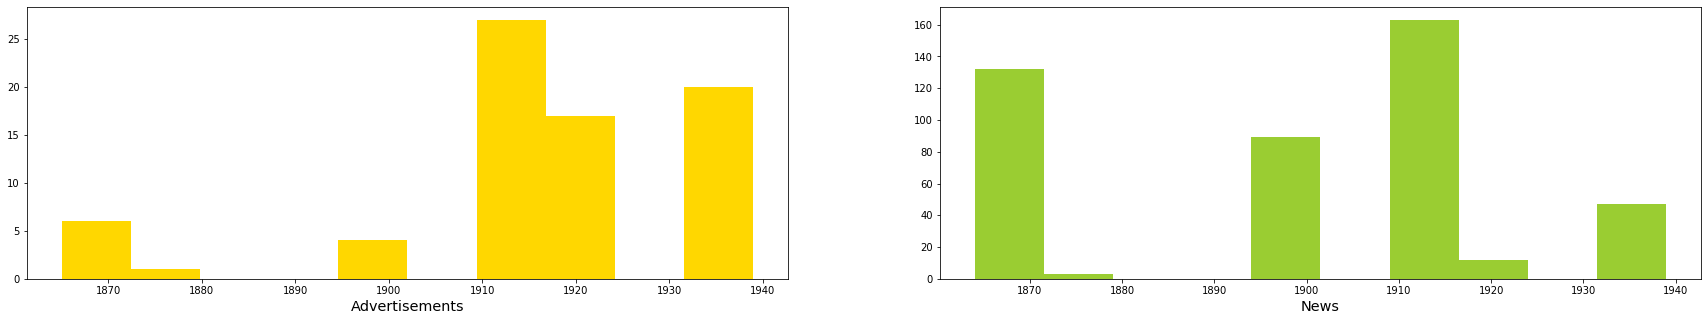

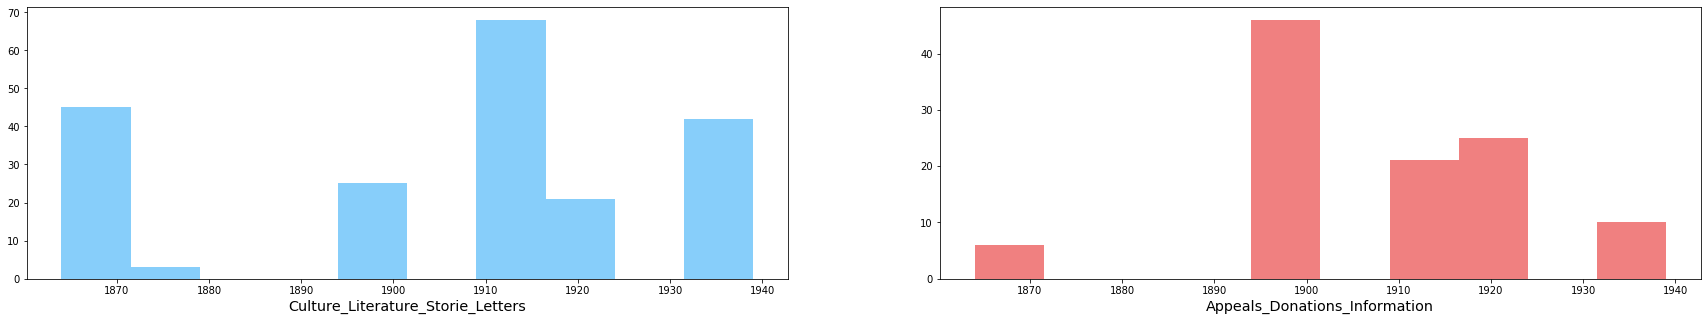

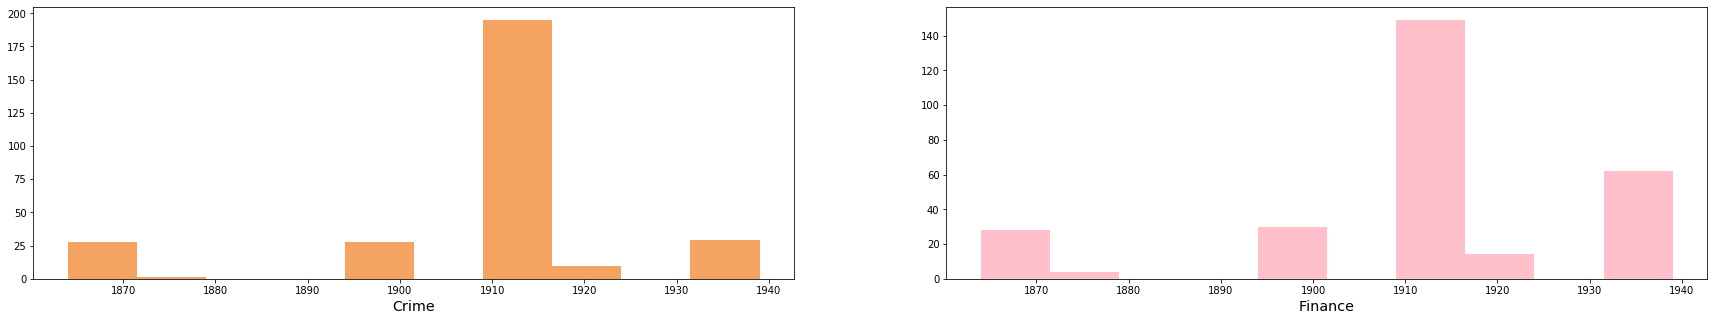

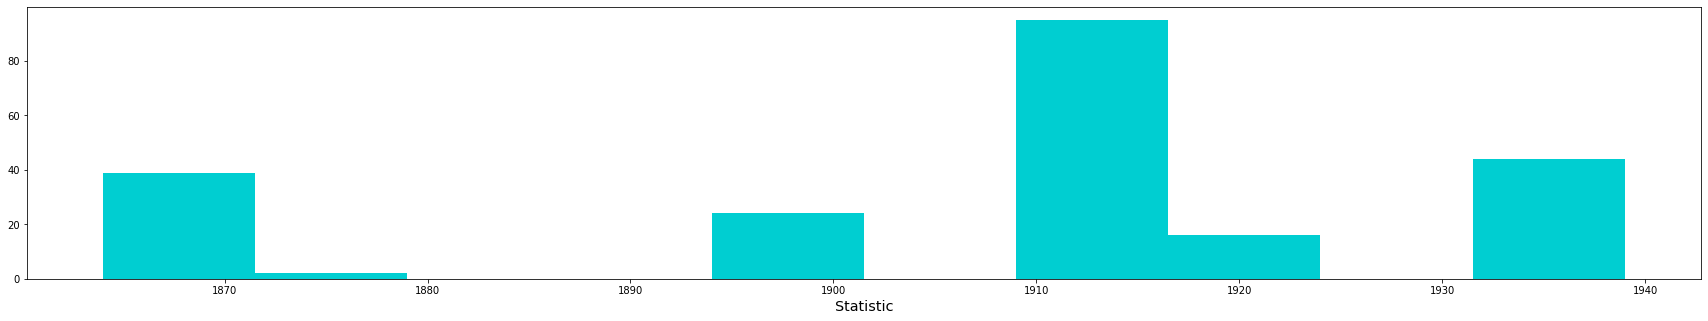

In [63]:
import matplotlib.axes as ax
plt.figure(figsize=(30, 5))

plt.subplot(121)
plt.hist(date_ads, color = 'gold', orientation="vertical")
plt.xlabel('Advertisements', size= 'x-large')
plt.subplot(122)
plt.hist(date_news, color = 'yellowgreen')
plt.xlabel('News', size= 'x-large')
plt.show()
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.hist(date_culture, color = 'lightskyblue')
plt.xlabel('Culture_Literature_Storie_Letters', size= 'x-large')
plt.subplot(122)
plt.hist(date_appeals, color = 'lightcoral')
plt.xlabel('Appeals_Donations_Information', size= 'x-large')
plt.show()
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.hist(date_crime, color = 'sandybrown')
plt.xlabel('Crime', size= 'x-large')
plt.subplot(122)
plt.hist(date_finance, color = 'pink')
plt.xlabel('Finance', size= 'x-large')
plt.figure(figsize=(30, 5))
plt.hist(date_statistic, color = 'darkturquoise')
plt.xlabel('Statistic', size= 'x-large')
plt.show()

